# LangGraph Overview

> Gain control with LangGraph to design agents that reliably handle complex tasks

Trusted by companies shaping the future of agents-- including Klarna, Replit, Elastic, and more-- LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.

LangGraph is very low-level, and focused entirely on agent **orchestration**. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.

LangGraph is focused on the underlying capabilities important for agent orchestration: durable execution, streaming, human-in-the-loop, and more.

## Install

First, install the required packages:

In [2]:
# Install required packages (uncomment to run)
# !pip install -U langgraph langchain-openai langchain-community chromadb

## Setup

Load environment variables and configure OpenAI:

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

# Make sure OPENAI_API_KEY is set in your .env file
print("OpenAI API Key loaded:", "OPENAI_API_KEY" in os.environ)

OpenAI API Key loaded: True


---

# Part 1: Basic LangGraph with OpenAI

## Hello World Example

Let's create a simple hello world example to understand the basic structure of a LangGraph application:

In [4]:
from langgraph.graph import StateGraph, MessagesState, START, END

def mock_llm(state: MessagesState):
    return {"messages": [{"role": "ai", "content": "hello world"}]}

graph = StateGraph(MessagesState)
graph.add_node(mock_llm)
graph.add_edge(START, "mock_llm")
graph.add_edge("mock_llm", END)
graph = graph.compile()

result = graph.invoke({"messages": [{"role": "user", "content": "hi!"}]})
print(result)

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='73d5c10a-f6e4-458e-a395-42acff95041a'), AIMessage(content='hello world', additional_kwargs={}, response_metadata={}, id='c092c819-d528-496d-a10a-40ac16606cc5', tool_calls=[], invalid_tool_calls=[])]}


## Using OpenAI as the LLM

Now let's replace the mock LLM with OpenAI's GPT model:

In [5]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_openai import ChatOpenAI

# Initialize OpenAI LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def call_llm(state: MessagesState):
    """Node that calls the OpenAI LLM."""
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

# Build the graph
graph = StateGraph(MessagesState)
graph.add_node("llm", call_llm)
graph.add_edge(START, "llm")
graph.add_edge("llm", END)

# Compile
app = graph.compile()

# Test it
result = app.invoke({"messages": [{"role": "user", "content": "What is LangGraph in one sentence?"}]})
print(result["messages"][-1].content)

/home/bella/miniforge3/envs/consulting/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LangGraph is a framework designed to facilitate the development and deployment of applications that leverage language models and graph-based data structures for enhanced natural language understanding and processing.


## Chatbot with Conversation History

LangGraph maintains state across invocations, making it perfect for chatbots:

In [6]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

def chatbot(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

# Build graph with memory
graph = StateGraph(MessagesState)
graph.add_node("chatbot", chatbot)
graph.add_edge(START, "chatbot")
graph.add_edge("chatbot", END)

# Add memory checkpointer
memory = MemorySaver()
app = graph.compile(checkpointer=memory)

# Configuration with thread_id for conversation tracking
config = {"configurable": {"thread_id": "conversation-1"}}

# First message
response1 = app.invoke({"messages": [HumanMessage(content="Hi! My name is Alice.")]}, config)
print("Bot:", response1["messages"][-1].content)

# Second message - bot should remember the name
response2 = app.invoke({"messages": [HumanMessage(content="What's my name?")]}, config)
print("Bot:", response2["messages"][-1].content)

Bot: Hi Alice! How can I assist you today?
Bot: Your name is Alice! How can I help you today?


---

# Part 2: RAG with LangGraph

Retrieval-Augmented Generation (RAG) combines document retrieval with LLM generation.

## Simple RAG Pipeline

In [7]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

# Define state for RAG
class RAGState(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Initialize components
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
embeddings = OpenAIEmbeddings()

# Create sample documents
documents = [
    Document(page_content="LangGraph is a library for building stateful, multi-actor applications with LLMs."),
    Document(page_content="LangGraph extends LangChain with cyclic graph capabilities for complex agent workflows."),
    Document(page_content="LangGraph supports persistence, streaming, and human-in-the-loop interactions."),
    Document(page_content="LangGraph uses nodes and edges to define the flow of data through an application."),
    Document(page_content="State in LangGraph is a shared data structure that gets updated as nodes execute."),
]

# Create vector store
vectorstore = Chroma.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

print("Vector store created with", len(documents), "documents")

Vector store created with 5 documents


In [8]:
# Define RAG nodes
def retrieve(state: RAGState):
    """Retrieve relevant documents."""
    docs = retriever.invoke(state["question"])
    return {"context": docs}

def generate(state: RAGState):
    """Generate answer using retrieved context."""
    context_text = "\n\n".join([doc.page_content for doc in state["context"]])
    
    prompt = f"""Answer the question based on the following context:

Context:
{context_text}

Question: {state["question"]}

Answer:"""
    
    response = llm.invoke(prompt)
    return {"answer": response.content}

# Build RAG graph
rag_graph = StateGraph(RAGState)
rag_graph.add_node("retrieve", retrieve)
rag_graph.add_node("generate", generate)

rag_graph.add_edge(START, "retrieve")
rag_graph.add_edge("retrieve", "generate")
rag_graph.add_edge("generate", END)

rag_app = rag_graph.compile()

# Test RAG
result = rag_app.invoke({"question": "What is LangGraph used for?"})
print("Question:", result["question"])
print("\nAnswer:", result["answer"])

Question: What is LangGraph used for?

Answer: LangGraph is used for building stateful, multi-actor applications with large language models (LLMs) and extends LangChain with cyclic graph capabilities for complex agent workflows.


## Advanced RAG with Query Rewriting

This example adds a query rewriting step to improve retrieval:

In [9]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langchain_core.documents import Document

class AdvancedRAGState(TypedDict):
    original_question: str
    rewritten_question: str
    context: List[Document]
    answer: str

def rewrite_query(state: AdvancedRAGState):
    """Rewrite the query to be more specific for retrieval."""
    prompt = f"""Rewrite this question to be more specific and better suited for document retrieval.
Only output the rewritten question, nothing else.

Original question: {state["original_question"]}

Rewritten question:"""
    
    response = llm.invoke(prompt)
    return {"rewritten_question": response.content}

def retrieve_advanced(state: AdvancedRAGState):
    """Retrieve using rewritten query."""
    docs = retriever.invoke(state["rewritten_question"])
    return {"context": docs}

def generate_advanced(state: AdvancedRAGState):
    """Generate answer with context."""
    context_text = "\n\n".join([doc.page_content for doc in state["context"]])
    
    prompt = f"""Answer the question based on the context provided.

Context:
{context_text}

Original Question: {state["original_question"]}

Provide a helpful and concise answer:"""
    
    response = llm.invoke(prompt)
    return {"answer": response.content}

# Build advanced RAG graph
advanced_rag = StateGraph(AdvancedRAGState)
advanced_rag.add_node("rewrite", rewrite_query)
advanced_rag.add_node("retrieve", retrieve_advanced)
advanced_rag.add_node("generate", generate_advanced)

advanced_rag.add_edge(START, "rewrite")
advanced_rag.add_edge("rewrite", "retrieve")
advanced_rag.add_edge("retrieve", "generate")
advanced_rag.add_edge("generate", END)

advanced_rag_app = advanced_rag.compile()

# Test
result = advanced_rag_app.invoke({"original_question": "How does state work?"})
print("Original:", result["original_question"])
print("Rewritten:", result["rewritten_question"])
print("\nAnswer:", result["answer"])

Original: How does state work?
Rewritten: What are the mechanisms and functions of state governance in political systems?

Answer: In LangGraph, state is a shared data structure that is updated as different nodes execute within the application. This allows for seamless communication and data sharing between multiple actors, enabling them to maintain and modify a consistent state throughout their interactions.


In [11]:
print(advanced_rag_app.get_graph().draw_ascii())

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
 +---------+   
 | rewrite |   
 +---------+   
      *        
      *        
      *        
+----------+   
| retrieve |   
+----------+   
      *        
      *        
      *        
+----------+   
| generate |   
+----------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


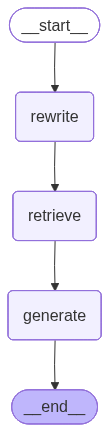

In [13]:
from IPython.display import Image, display
image= advanced_rag_app.get_graph().draw_mermaid_png()
display(Image(image))

In [26]:
result

{'original_question': 'How does state work?',
 'rewritten_question': 'What are the mechanisms and functions of state governance in political systems?',
 'context': [Document(metadata={}, page_content='LangGraph is a library for building stateful, multi-actor applications with LLMs.'),
  Document(metadata={}, page_content='State in LangGraph is a shared data structure that gets updated as nodes execute.')],
 'answer': 'In LangGraph, state is a shared data structure that is updated as different nodes execute within the application. This allows for seamless communication and data sharing between multiple actors, enabling them to maintain and modify a consistent state throughout their interactions.'}

## RAG with Relevance Check (Conditional Routing)

This example adds a node to check if retrieved documents are relevant, and routes accordingly:

In [15]:
from typing import TypedDict, List, Literal
from langgraph.graph import StateGraph, START, END
from langchain_core.documents import Document

class RAGWithCheckState(TypedDict):
    question: str
    context: List[Document]
    relevance: str  # "relevant" or "not_relevant"
    answer: str

def retrieve_docs(state: RAGWithCheckState):
    docs = retriever.invoke(state["question"])
    return {"context": docs}

def check_relevance(state: RAGWithCheckState):
    """Check if retrieved documents are relevant to the question."""
    context_text = "\n".join([doc.page_content for doc in state["context"]])
    
    prompt = f"""Determine if the following context is relevant to answer the question.
Answer only 'relevant' or 'not_relevant'.

Context: {context_text}

Question: {state["question"]}

Relevance:"""
    
    response = llm.invoke(prompt)
    relevance = "relevant" if "relevant" in response.content.lower() and "not" not in response.content.lower() else "not_relevant"
    return {"relevance": relevance}

def route_on_relevance(state: RAGWithCheckState) -> Literal["generate", "fallback"]:
    """Route based on relevance check."""
    if state["relevance"] == "relevant":
        return "generate"
    return "fallback"

def generate_with_context(state: RAGWithCheckState):
    context_text = "\n\n".join([doc.page_content for doc in state["context"]])
    prompt = f"""Answer based on the context:

Context: {context_text}

Question: {state["question"]}

Answer:"""
    response = llm.invoke(prompt)
    return {"answer": response.content}

def fallback_response(state: RAGWithCheckState):
    """Generate response without context when documents aren't relevant."""
    prompt = f"Answer this question to the best of your knowledge: {state['question']}"
    response = llm.invoke(prompt)
    return {"answer": f"(No relevant documents found) {response.content}"}

# Build graph with conditional routing
rag_check = StateGraph(RAGWithCheckState)
rag_check.add_node("retrieve", retrieve_docs)
rag_check.add_node("check", check_relevance)
rag_check.add_node("generate", generate_with_context)
rag_check.add_node("fallback", fallback_response)

rag_check.add_edge(START, "retrieve")
rag_check.add_edge("retrieve", "check")
rag_check.add_conditional_edges("check", route_on_relevance)
rag_check.add_edge("generate", END)
rag_check.add_edge("fallback", END)

rag_check_app = rag_check.compile()

# Test with relevant question
result1 = rag_check_app.invoke({"question": "What is LangGraph?"})
print("Q1:", result1["question"])
print("Relevance:", result1["relevance"])
print("Answer:", result1["answer"])

print("\n" + "="*50 + "\n")

# Test with unrelated question
result2 = rag_check_app.invoke({"question": "What is the capital of France?"})
print("Q2:", result2["question"])
print("Relevance:", result2["relevance"])
print("Answer:", result2["answer"])

Q1: What is LangGraph?
Relevance: relevant
Answer: LangGraph is a library that enhances LangChain by adding cyclic graph capabilities, allowing for the development of stateful, multi-actor applications that utilize large language models (LLMs) for complex agent workflows.


Q2: What is the capital of France?
Relevance: not_relevant
Answer: (No relevant documents found) The capital of France is Paris.


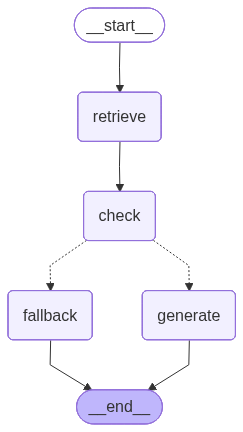

In [16]:
from IPython.display import Image, display
image= rag_check_app.get_graph().draw_mermaid_png()
display(Image(image))

---

# Part 3: Workflow Examples

LangGraph excels at building complex workflows with multiple steps, conditions, and loops.

## Linear Workflow: Content Processing Pipeline

In [18]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class ContentState(TypedDict):
    raw_text: str
    summary: str
    keywords: str
    sentiment: str
    final_report: str

def summarize(state: ContentState):
    prompt = f"Summarize this text in 2 sentences:\n\n{state['raw_text']}"
    response = llm.invoke(prompt)
    return {"summary": response.content}

def extract_keywords(state: ContentState):
    prompt = f"Extract 5 key topics/keywords from this text as a comma-separated list:\n\n{state['raw_text']}"
    response = llm.invoke(prompt)
    return {"keywords": response.content}

def analyze_sentiment(state: ContentState):
    prompt = f"Analyze the sentiment of this text (positive/negative/neutral) and explain briefly:\n\n{state['raw_text']}"
    response = llm.invoke(prompt)
    return {"sentiment": response.content}

def create_report(state: ContentState):
    report = f"""=== CONTENT ANALYSIS REPORT ===

SUMMARY:
{state['summary']}

KEYWORDS:
{state['keywords']}

SENTIMENT:
{state['sentiment']}
"""
    return {"final_report": report}

# Build pipeline
pipeline = StateGraph(ContentState)
pipeline.add_node("summarize", summarize)
pipeline.add_node("keywords", extract_keywords)
pipeline.add_node("sentiment", analyze_sentiment)
pipeline.add_node("report", create_report)

pipeline.add_edge(START, "summarize")
pipeline.add_edge("summarize", "keywords")
pipeline.add_edge("keywords", "sentiment")
pipeline.add_edge("sentiment", "report")
pipeline.add_edge("report", END)

content_app = pipeline.compile()

# Test
sample_text = """
Artificial Intelligence is transforming industries worldwide. From healthcare diagnostics 
to autonomous vehicles, AI applications are becoming more sophisticated and widespread. 
However, concerns about job displacement and ethical implications continue to spark debate. 
Despite these challenges, investment in AI research continues to grow exponentially, 
with major tech companies leading the charge toward more advanced machine learning systems.
"""

result = content_app.invoke({"raw_text": sample_text})
print(result["final_report"])

=== CONTENT ANALYSIS REPORT ===

SUMMARY:
Artificial Intelligence is revolutionizing various industries, including healthcare and transportation, with increasingly advanced applications. While concerns about job displacement and ethical issues persist, investment in AI research is rapidly increasing, driven by major tech companies.

KEYWORDS:
Artificial Intelligence, healthcare diagnostics, autonomous vehicles, job displacement, ethical implications

SENTIMENT:
The sentiment of the text is **neutral**. 

While the text discusses both the positive aspects of artificial intelligence, such as its transformative impact on industries and the growth of investment in AI research, it also addresses negative concerns, including job displacement and ethical implications. The balanced presentation of both the benefits and challenges associated with AI leads to a neutral sentiment overall, as it does not lean strongly towards either a positive or negative viewpoint.



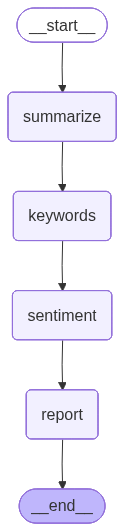

In [19]:
from IPython.display import Image, display
image= content_app.get_graph().draw_mermaid_png()
display(Image(image))

## Parallel Workflow: Multiple Analyses at Once

Run multiple independent tasks in parallel and combine results:

In [20]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class ParallelState(TypedDict):
    text: str
    translation_spanish: str
    translation_french: str
    translation_german: str
    combined: str

def translate_spanish(state: ParallelState):
    prompt = f"Translate to Spanish:\n{state['text']}"
    response = llm.invoke(prompt)
    return {"translation_spanish": response.content}

def translate_french(state: ParallelState):
    prompt = f"Translate to French:\n{state['text']}"
    response = llm.invoke(prompt)
    return {"translation_french": response.content}

def translate_german(state: ParallelState):
    prompt = f"Translate to German:\n{state['text']}"
    response = llm.invoke(prompt)
    return {"translation_german": response.content}

def combine_translations(state: ParallelState):
    combined = f"""Original: {state['text']}

Spanish: {state['translation_spanish']}

French: {state['translation_french']}

German: {state['translation_german']}
"""
    return {"combined": combined}

# Build parallel graph
parallel_graph = StateGraph(ParallelState)
parallel_graph.add_node("spanish", translate_spanish)
parallel_graph.add_node("french", translate_french)
parallel_graph.add_node("german", translate_german)
parallel_graph.add_node("combine", combine_translations)

# Fan out to parallel nodes
parallel_graph.add_edge(START, "spanish")
parallel_graph.add_edge(START, "french")
parallel_graph.add_edge(START, "german")

# Fan in to combine
parallel_graph.add_edge("spanish", "combine")
parallel_graph.add_edge("french", "combine")
parallel_graph.add_edge("german", "combine")
parallel_graph.add_edge("combine", END)

parallel_app = parallel_graph.compile()

# Test
result = parallel_app.invoke({"text": "Hello, how are you today?"})
print(result["combined"])

Original: Hello, how are you today?

Spanish: Hola, ¿cómo estás hoy?

French: Bonjour, comment ça va aujourd'hui ?

German: Hallo, wie geht es dir heute?



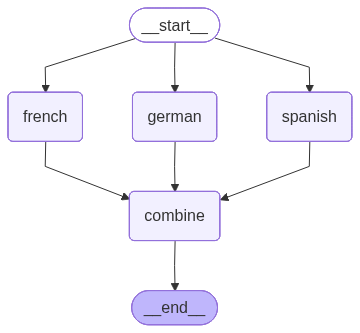

In [21]:
from IPython.display import Image, display
image= parallel_app.get_graph().draw_mermaid_png()
display(Image(image))

## Conditional Workflow: Routing Based on Classification

In [24]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END

class TicketState(TypedDict):
    ticket: str
    category: str
    response: str

def classify_ticket(state: TicketState):
    """Classify the support ticket."""


    prompt = f"""Classify this support ticket into one of these categories:
- billing
- technical
- general

Only respond with the category name, nothing else.

Ticket: {state['ticket']}

Category:"""
    

    response = llm.invoke(prompt)
    category = response.content.strip().lower()
    if category not in ["billing", "technical", "general"]:
        category = "general"
    return {"category": category}

def route_ticket(state: TicketState) -> Literal["billing_handler", "technical_handler", "general_handler"]:
    """Route to appropriate handler."""
    if state["category"] == "billing":
        return "billing_handler"
    elif state["category"] == "technical":
        return "technical_handler"
    return "general_handler"

def handle_billing(state: TicketState):
    prompt = f"You are a billing support specialist. Help with this issue:\n{state['ticket']}"
    response = llm.invoke(prompt)
    return {"response": f"[BILLING TEAM] {response.content}"}

def handle_technical(state: TicketState):
    prompt = f"You are a technical support engineer. Help with this issue:\n{state['ticket']}"
    response = llm.invoke(prompt)
    return {"response": f"[TECHNICAL TEAM] {response.content}"}

def handle_general(state: TicketState):
    prompt = f"You are a customer support representative. Help with this inquiry:\n{state['ticket']}"
    response = llm.invoke(prompt)
    return {"response": f"[GENERAL SUPPORT] {response.content}"}

# Build routing graph
ticket_graph = StateGraph(TicketState)
ticket_graph.add_node("classify", classify_ticket)
ticket_graph.add_node("billing_handler", handle_billing)
ticket_graph.add_node("technical_handler", handle_technical)
ticket_graph.add_node("general_handler", handle_general)

ticket_graph.add_edge(START, "classify")
ticket_graph.add_conditional_edges("classify", route_ticket)
ticket_graph.add_edge("billing_handler", END)
ticket_graph.add_edge("technical_handler", END)
ticket_graph.add_edge("general_handler", END)

ticket_app = ticket_graph.compile()

# Test different ticket types
tickets = [
    "I was charged twice for my subscription this month!",
    "The app keeps crashing when I try to upload files.",
    "What are your business hours?"
]

for ticket in tickets:
    result = ticket_app.invoke({"ticket": ticket})
    print(f"Ticket: {ticket}")
    print(f"Category: {result['category']}")
    print(f"Response: {result['response'][:]}...\n")
    print("="*50 + "\n")

Ticket: I was charged twice for my subscription this month!
Category: billing
Response: [BILLING TEAM] I’m sorry to hear that you were charged twice for your subscription. Let’s work together to resolve this issue. Here are a few steps you can take:

1. **Check Your Account**: Log into your account and review your billing history. This will help you confirm the duplicate charges.

2. **Payment Method**: Verify that the payment method you used is correct and that there are no pending transactions that could have caused confusion.

3. **Contact Support**: If you confirm that you were indeed charged twice, please reach out to our billing support team directly. Provide them with the following information:
   - Your account email or username
   - The date of the charges
   - The amount charged
   - Any transaction IDs if available

4. **Refund Process**: Once we have your information, we can investigate the issue and initiate a refund for the duplicate charge if applicable.

5. **Future Pre

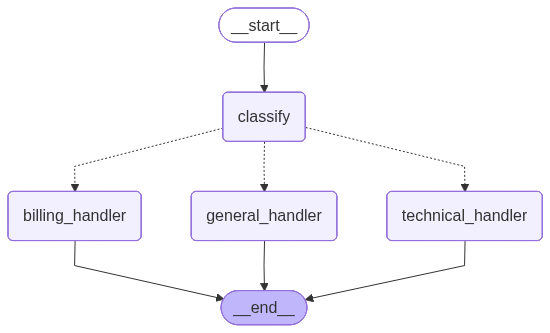

In [23]:
from IPython.display import Image, display
image= ticket_app.get_graph().draw_mermaid_png()
display(Image(image))

## Loop Workflow: Iterative Refinement

In [27]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END

class WritingState(TypedDict):
    topic: str
    draft: str
    feedback: str
    iteration: int
    max_iterations: int
    is_approved: bool

def write_draft(state: WritingState):
    """Write or rewrite the draft."""
    if state.get("draft"):
        prompt = f"""Improve this draft based on the feedback:

Current draft: {state['draft']}

Feedback: {state['feedback']}

Write an improved version:"""
    else:
        prompt = f"Write a short paragraph (3-4 sentences) about: {state['topic']}"
    
    response = llm.invoke(prompt)
    return {
        "draft": response.content,
        "iteration": state.get("iteration", 0) + 1
    }

def review_draft(state: WritingState):
    """Review and provide feedback."""
    prompt = f"""Review this draft and decide if it's good enough.
If it needs improvement, provide specific feedback.
If it's good, say 'APPROVED'.

Draft: {state['draft']}

Your review:"""
    
    response = llm.invoke(prompt)
    is_approved = "APPROVED" in response.content.upper()
    return {
        "feedback": response.content,
        "is_approved": is_approved
    }

def should_continue(state: WritingState) -> Literal["write", "__end__"]:
    """Decide whether to continue refining or finish."""
    if state["is_approved"]:
        return END
    if state["iteration"] >= state.get("max_iterations", 3):
        return END
    return "write"

# Build iterative graph
writing_graph = StateGraph(WritingState)
writing_graph.add_node("write", write_draft)
writing_graph.add_node("review", review_draft)

writing_graph.add_edge(START, "write")
writing_graph.add_edge("write", "review")
writing_graph.add_conditional_edges("review", should_continue)

writing_app = writing_graph.compile()

# Test
result = writing_app.invoke({
    "topic": "The benefits of morning exercise",
    "max_iterations": 3,
    "iteration": 0,
    "is_approved": False
})

print(f"Iterations: {result['iteration']}")
print(f"Approved: {result['is_approved']}")
print(f"\nFinal Draft:\n{result['draft']}")

Iterations: 1
Approved: True

Final Draft:
Morning exercise offers a multitude of benefits that can enhance both physical and mental well-being. Engaging in physical activity early in the day boosts metabolism, helping to burn calories more efficiently throughout the day. Additionally, morning workouts can improve mood and increase energy levels, setting a positive tone for the hours ahead. Establishing a consistent morning routine also fosters discipline and can lead to better overall health habits.


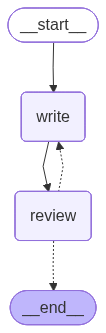

In [26]:
from IPython.display import Image, display
image= writing_app.get_graph().draw_mermaid_png()
display(Image(image))

## Agent with Tools

Create an agent that can use tools to complete tasks:

In [28]:
from typing import TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, ToolMessage

# Define tools
@tool
def calculator(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations."""
    try:
        result = eval(expression)
        return str(result)
    except Exception as e:
        return f"Error: {e}"

@tool
def get_weather(city: str) -> str:
    """Get the current weather for a city. Use this when asked about weather."""
    # Mock weather data
    weather_data = {
        "new york": "Sunny, 72°F",
        "london": "Cloudy, 58°F",
        "tokyo": "Rainy, 65°F",
        "paris": "Partly cloudy, 68°F"
    }
    return weather_data.get(city.lower(), f"Weather data not available for {city}")

# Create LLM with tools
tools = [calculator, get_weather]
llm_with_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

def agent(state: MessagesState):
    """Call the LLM with tools."""
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

def tool_executor(state: MessagesState):
    """Execute tool calls."""
    last_message = state["messages"][-1]
    tool_results = []
    
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        if tool_name == "calculator":
            result = calculator.invoke(tool_args)
        elif tool_name == "get_weather":
            result = get_weather.invoke(tool_args)
        else:
            result = f"Unknown tool: {tool_name}"
        
        tool_results.append(
            ToolMessage(content=result, tool_call_id=tool_call["id"])
        )
    
    return {"messages": tool_results}

def should_use_tools(state: MessagesState) -> Literal["tools", "__end__"]:
    """Check if the LLM wants to use tools."""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

# Build agent graph
agent_graph = StateGraph(MessagesState)
agent_graph.add_node("agent", agent)
agent_graph.add_node("tools", tool_executor)

agent_graph.add_edge(START, "agent")
agent_graph.add_conditional_edges("agent", should_use_tools)
agent_graph.add_edge("tools", "agent")  # Loop back after tool execution

agent_app = agent_graph.compile()

# Test the agent
print("Test 1: Math question")
result = agent_app.invoke({"messages": [HumanMessage(content="What is 25 * 17 + 83?")]})
print(result["messages"][-1].content)

print("\nTest 2: Weather question")
result = agent_app.invoke({"messages": [HumanMessage(content="What's the weather in Tokyo?")]})
print(result["messages"][-1].content)

print("\nTest 3: Combined question")
result = agent_app.invoke({"messages": [HumanMessage(content="What's the weather in London and also calculate 100/4?")]})
print(result["messages"][-1].content)

Test 1: Math question
The result of \( 25 \times 17 + 83 \) is 508.

Test 2: Weather question
The weather in Tokyo is rainy, with a temperature of 65°F.

Test 3: Combined question
The weather in London is cloudy with a temperature of 58°F. Additionally, the result of the calculation \(100 \div 4\) is 25.0.


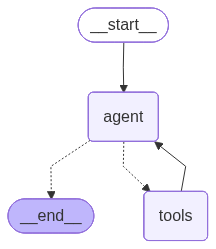

In [29]:
from IPython.display import Image, display
image= agent_app.get_graph().draw_mermaid_png()
display(Image(image))

---

## Core Benefits Summary

LangGraph provides low-level supporting infrastructure for *any* long-running, stateful workflow or agent:

* **Durable execution**: Build agents that persist through failures and can run for extended periods
* **Human-in-the-loop**: Incorporate human oversight by inspecting and modifying agent state at any point
* **Comprehensive memory**: Create stateful agents with both short-term and long-term memory
* **Debugging with LangSmith**: Gain deep visibility into complex agent behavior
* **Production-ready deployment**: Deploy sophisticated agent systems with scalable infrastructure

---

**Documentation**: https://docs.langchain.com/llms.txt